In [65]:
## ========================== Import Package ========================== ##

import numpy as np
import math
import matplotlib.pyplot as plt
import time

## ========================== Parameter Declaration ========================== ##

filter_order = 6
train_sample = 200
num_repeat = 1

## =========================== Generate Sampeles =========================== ##

signal_xy = np.loadtxt('sun_spot_input.asc')
signal_xy = signal_xy/max(signal_xy)

signal_x_train = np.array([signal_xy[i-filter_order:i][::-1] for i in range(filter_order, train_sample + filter_order)])
signal_y_train = signal_xy[filter_order:train_sample + filter_order]

signal_x_train_repeat = signal_x_train.copy()
signal_y_train_repeat = signal_y_train.copy()
for i in range (num_repeat):
    signal_x_train_repeat = np.vstack((signal_x_train_repeat, signal_x_train_repeat))
    signal_y_train_repeat = np.hstack((signal_y_train_repeat, signal_y_train_repeat))

signal_x_test = np.array([signal_xy[i-filter_order:i][::-1] for i in range(train_sample + filter_order, len(signal_xy))])
signal_y_test = signal_xy[train_sample + filter_order:len(signal_xy)]

In [66]:
# QKLMS Algorithm

mu = 0.01 # step size
kernel_size = np.array([0.01, 0.05, 0.1, 0.2, 0.5, 0.8, 1.0, 2.0, 5.0]) # , 
h_vector = 1 / (2 * kernel_size ** 2) # parameter of Gaussian kernel
delta = 0 # quantization threshold

# define kernel
def kernel(x1, x2, h):
    return np.exp(-h * np.sum((x1 - x2) ** 2, axis = 1))


# define QKLMS
MSE_error = []
yyy = []
QKLMS_trainMSE_store = np.zeros((len(kernel_size), len(signal_x_train_repeat)))
QKLMS_testMSE_store = np.zeros((len(kernel_size), len(signal_x_train_repeat)))

QKLMS_start = time.time()
for mmm in range (len(kernel_size)):
    h_x = h_vector[mmm]
    
    QKLMS_center_list = []
    QKLMS_alpha_list = []
    QKLMS_network_size = []
    
    for i in range (len(signal_x_train_repeat)):
        if i == 0:
            filter_output = 0
            QKLMS_alpha_list.append(mu * (signal_y_train_repeat[i] - filter_output))
            QKLMS_center_list.append(signal_x_train_repeat[i])
        else:
            filter_output = np.array(QKLMS_alpha_list) @ kernel(signal_x_train_repeat[i], np.array(QKLMS_center_list), h_x)            
            if i <= 1:
                dist_min = np.linalg.norm(signal_x_train_repeat[i] - np.array(QKLMS_center_list))
                dist_min_index = np.argmin(dist_min)
            else:
                dist_store = np.linalg.norm(signal_x_train_repeat[i] - np.array(QKLMS_center_list), axis = 1)
                dist_min_index = np.argmin(dist_store)
                dist_min = min(dist_store)
            if dist_min <= delta:
                QKLMS_alpha_list[dist_min_index] = QKLMS_alpha_list[dist_min_index] + mu * (signal_y_train_repeat[i] - filter_output)
            else:
                QKLMS_alpha_list.append(mu * (signal_y_train_repeat[i] - filter_output))
                QKLMS_center_list.append(signal_x_train_repeat[i])
        yyy.append(filter_output)
        MSE_error.append((signal_y_train_repeat[i] - filter_output) ** 2)
        
        QKLMS_train_error = np.zeros(len(signal_x_train))
        QKLMS_test_error = np.zeros(len(signal_x_test))
        for iii in range(len(signal_x_train)): 
            QKLMS_train_error[iii] = np.array(QKLMS_alpha_list) @ kernel(signal_x_train[iii], np.array(QKLMS_center_list), h_x)
        for jjj in range(len(signal_x_test)): 
            QKLMS_test_error[jjj] = np.array(QKLMS_alpha_list) @ kernel(signal_x_test[jjj], np.array(QKLMS_center_list), h_x)
        QKLMS_trainMSE_store[mmm][i] = np.sum((signal_y_train - QKLMS_train_error) ** 2) / len(signal_y_train)
        QKLMS_testMSE_store[mmm][i] = np.sum((signal_y_test - QKLMS_test_error) ** 2) / len(signal_y_test)
        QKLMS_network_size.append(len(QKLMS_center_list))
        

QKLMS_end = time.time()
print('The time of execution using QKLMS:', QKLMS_end - QKLMS_start)

The time of execution using QKLMS: 459.93012142181396


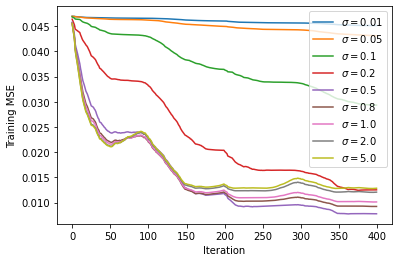

In [67]:
# Learning curve of training MSE

l1 = plt.plot(QKLMS_trainMSE_store[0])
l2 = plt.plot(QKLMS_trainMSE_store[1])
l3 = plt.plot(QKLMS_trainMSE_store[2])
l4 = plt.plot(QKLMS_trainMSE_store[3])
l5 = plt.plot(QKLMS_trainMSE_store[4])
l6 = plt.plot(QKLMS_trainMSE_store[5])
l7 = plt.plot(QKLMS_trainMSE_store[6])
l8 = plt.plot(QKLMS_trainMSE_store[7])
l9 = plt.plot(QKLMS_trainMSE_store[8])
plt.xlabel('Iteration')
plt.ylabel('Training MSE')
plt.legend([r'$\sigma=0.01$', r'$\sigma=0.05$', r'$\sigma=0.1$', r'$\sigma=0.2$', r'$\sigma=0.5$', r'$\sigma=0.8$', r'$\sigma=1.0$', r'$\sigma=2.0$', r'$\sigma=5.0$'])
plt.show()

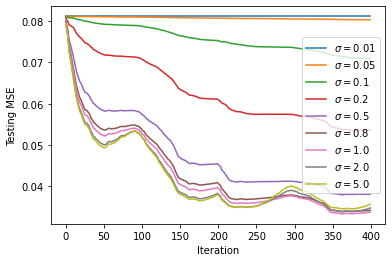

In [6]:
# Learning curve of testing MSE

l1 = plt.plot(QKLMS_testMSE_store[0])
l2 = plt.plot(QKLMS_testMSE_store[1])
l3 = plt.plot(QKLMS_testMSE_store[2])
l4 = plt.plot(QKLMS_testMSE_store[3])
l5 = plt.plot(QKLMS_testMSE_store[4])
l6 = plt.plot(QKLMS_testMSE_store[5])
l7 = plt.plot(QKLMS_testMSE_store[6])
l8 = plt.plot(QKLMS_testMSE_store[7])
l9 = plt.plot(QKLMS_testMSE_store[8])
plt.xlabel('Iteration')
plt.ylabel('Testing MSE')
plt.legend([r'$\sigma=0.01$', r'$\sigma=0.05$', r'$\sigma=0.1$', r'$\sigma=0.2$', r'$\sigma=0.5$', r'$\sigma=0.8$', r'$\sigma=1.0$', r'$\sigma=2.0$', r'$\sigma=5.0$'])
plt.show()

In [12]:
QKLMS_testMSE_store[:, -1]

array([0.08115438, 0.08029768, 0.07091082, 0.05361613, 0.03807333,
       0.0341913 , 0.03378161, 0.03477415, 0.03570204])

In [7]:
# QKRLS Algorithm

lamda = 1
delta = 0.2 # quantization threshold

# define kernel
def kernel(x1, x2, h):
    return np.exp(-h * np.sum((x1 - x2) ** 2, axis = 1))

# define QKRLS

QKRLS_trainMSE_store = np.zeros((len(kernel_size), len(signal_x_train_repeat)))
QKRLS_testMSE_store = np.zeros((len(kernel_size), len(signal_x_train_repeat)))


QKRLS_start = time.time()


for mmm in range (len(kernel_size)):
    h_x = h_vector[mmm]
    
    QKRLS_center_list = [] # h
    QKRLS_alpha_list = [] # a
    QKRLS_Q_list = [] # Q
    QKRLS_network_size = []
    QKRLS_diag_store = []
    for i in range (len(signal_x_train_repeat)):
        if i == 0:
            filter_output = 0
            QKRLS_center_list.append(signal_x_train_repeat[i])
            QKRLS_Q_list.append(1 / (lamda + kernel(signal_x_train_repeat[i], np.array(QKRLS_center_list), h_x)))
            QKRLS_alpha_list.append(QKRLS_Q_list[0] * signal_y_train_repeat[i])
            QKRLS_diag_store.append(np.array([1]))
        else:        
            kernel_h = kernel(signal_x_train_repeat[i], np.array(QKRLS_center_list), h_x)
            filter_output = kernel_h.T @ np.array(QKRLS_alpha_list)
            error = signal_y_train_repeat[i] - filter_output
            if i <= 1:
                dist_min = np.linalg.norm(signal_x_train_repeat[i] - np.array(QKRLS_center_list))
                dist_min_index = np.argmin(dist_min)
            else:
                dist_store = np.linalg.norm(signal_x_train_repeat[i] - np.array(QKRLS_center_list), axis = 1)
                dist_min_index = np.argmin(dist_store)
                dist_min = min(dist_store)
            if dist_min <= delta:
                sign_vector = np.zeros(len(QKRLS_diag_store)).reshape(-1, 1)
                sign_vector[dist_min_index] = 1
                QKRLS_diag_store = QKRLS_diag_store + sign_vector @ sign_vector.T
                kernel_dist_min = kernel(QKRLS_center_list[dist_min_index], np.array(QKRLS_center_list), h_x)
                if len(QKRLS_Q_list) == 1:
                    QKRLS_alpha_list = QKRLS_alpha_list + QKRLS_Q_list[dist_min_index].reshape(-1, 1) * (signal_y_train_repeat[i] - kernel_dist_min @ QKRLS_alpha_list) / (1 + kernel_dist_min @ QKRLS_Q_list[dist_min_index])
                    QKRLS_Q_list = QKRLS_Q_list - QKRLS_Q_list[dist_min_index].reshape(-1, 1) @ (kernel_dist_min @ QKRLS_Q_list).reshape(1, -1) / (1 + kernel_dist_min @ QKRLS_Q_list[dist_min_index])
                else:
                    QKRLS_alpha_list = QKRLS_alpha_list + QKRLS_Q_list[:, dist_min_index].reshape(-1, 1) * (signal_y_train_repeat[i] - kernel_dist_min @ QKRLS_alpha_list) / (1 + kernel_dist_min @ QKRLS_Q_list[:, dist_min_index])
                    QKRLS_Q_list = QKRLS_Q_list - QKRLS_Q_list[:, dist_min_index].reshape(-1, 1) @ (kernel_dist_min @ QKRLS_Q_list).reshape(1, -1) / (1 + kernel_dist_min @ QKRLS_Q_list[:, dist_min_index])
            else:
                z = np.array(QKRLS_Q_list).T @ kernel_h
                z_diag = np.array(QKRLS_Q_list) @ QKRLS_diag_store @ kernel_h
                r = lamda + kernel(signal_x_train_repeat[i], np.array([signal_x_train_repeat[i]]), h_x) - z.T @ kernel_h
                QKRLS_Q_list = QKRLS_Q_list + 1 / r * (z_diag.reshape(-1, 1) @ z.reshape(1, -1)) 
                QKRLS_Q_list = np.hstack((QKRLS_Q_list, np.array([- z_diag / r]).T))
                QKRLS_Q_list = np.vstack((QKRLS_Q_list, np.hstack((- 1 / r * z.T, 1 / r))))
                QKRLS_alpha_list = QKRLS_alpha_list - (z_diag * error / r).reshape(-1, 1)
                QKRLS_alpha_list = np.vstack((QKRLS_alpha_list, error / r))
                QKRLS_center_list.append(signal_x_train_repeat[i])
                QKRLS_diag_store = np.hstack((QKRLS_diag_store, np.zeros(len(QKRLS_diag_store)).reshape(-1, 1)))
                QKRLS_diag_store = np.vstack((QKRLS_diag_store, np.hstack((np.zeros(len(QKRLS_diag_store)), 1)).reshape(1, -1)))
        
        QKRLS_train_error = np.zeros(len(signal_x_train))
        QKRLS_test_error = np.zeros(len(signal_x_test))
        for iii in range(len(signal_x_train)):
            QKRLS_train_error[iii] = kernel(signal_x_train[iii], np.array(QKRLS_center_list), h_x).T @ np.array(QKRLS_alpha_list)
        for jjj in range(len(signal_x_test)): 
            QKRLS_test_error[jjj] = kernel(signal_x_test[jjj], np.array(QKRLS_center_list), h_x).T @ np.array(QKRLS_alpha_list)
        QKRLS_trainMSE_store[mmm][i] = np.sum((signal_y_train - QKRLS_train_error) ** 2) / len(signal_y_train)
        QKRLS_testMSE_store[mmm][i] = np.sum((signal_y_test - QKRLS_test_error) ** 2) / len(signal_y_test)

        QKRLS_network_size.append(len(QKRLS_center_list))

QKRLS_end = time.time()
print('The time of execution using QKRLS:', QKRLS_end - QKRLS_start)

The time of execution using QKRLS: 136.01576590538025


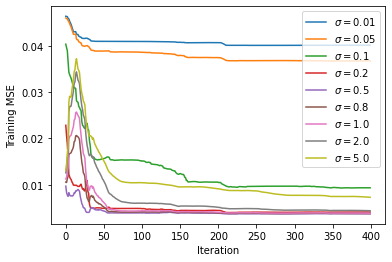

In [8]:
# Learning curve of training MSE

l1 = plt.plot(QKRLS_trainMSE_store[0])
l2 = plt.plot(QKRLS_trainMSE_store[1])
l3 = plt.plot(QKRLS_trainMSE_store[2])
l4 = plt.plot(QKRLS_trainMSE_store[3])
l5 = plt.plot(QKRLS_trainMSE_store[4])
l6 = plt.plot(QKRLS_trainMSE_store[5])
l7 = plt.plot(QKRLS_trainMSE_store[6])
l8 = plt.plot(QKRLS_trainMSE_store[7])
l9 = plt.plot(QKRLS_trainMSE_store[8])
plt.xlabel('Iteration')
plt.ylabel('Training MSE')
plt.legend([r'$\sigma=0.01$', r'$\sigma=0.05$', r'$\sigma=0.1$', r'$\sigma=0.2$', r'$\sigma=0.5$', r'$\sigma=0.8$', r'$\sigma=1.0$', r'$\sigma=2.0$', r'$\sigma=5.0$'])
plt.show()

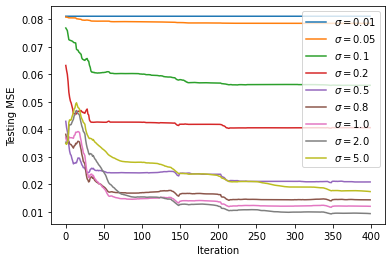

In [9]:
# Learning curve of testing MSE

l1 = plt.plot(QKRLS_testMSE_store[0])
l2 = plt.plot(QKRLS_testMSE_store[1])
l3 = plt.plot(QKRLS_testMSE_store[2])
l4 = plt.plot(QKRLS_testMSE_store[3])
l5 = plt.plot(QKRLS_testMSE_store[4])
l6 = plt.plot(QKRLS_testMSE_store[5])
l7 = plt.plot(QKRLS_testMSE_store[6])
l8 = plt.plot(QKRLS_testMSE_store[7])
l9 = plt.plot(QKRLS_testMSE_store[8])
plt.xlabel('Iteration')
plt.ylabel('Testing MSE')
plt.legend([r'$\sigma=0.01$', r'$\sigma=0.05$', r'$\sigma=0.1$', r'$\sigma=0.2$', r'$\sigma=0.5$', r'$\sigma=0.8$', r'$\sigma=1.0$', r'$\sigma=2.0$', r'$\sigma=5.0$'])
plt.show()

In [14]:
QKRLS_trainMSE_store[:, -1]

array([0.04014388, 0.03674064, 0.00933434, 0.00409017, 0.00371787,
       0.00376414, 0.00383493, 0.00437685, 0.00728036])

In [17]:
## =================================================== Q1 AND Q2 ======================================================##